In [1]:
import multiprocessing as mp
from util.backtest import *
from util.factor_util import *
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from tqdm import tqdm
import warnings
from time import sleep
import statsmodels.api as sm
import os
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False

In [14]:
INSAMPLE_END_DATE = datetime(2021,7,1)
VALID_END_DATE = datetime(2022,6,1)
SAMPLE_END_DATE = datetime(2022,8,31)

FREQ = 'D'


# df = pd.read_csv('/home/frank/document/Python/Factors/data/data_1h.csv')
symbol_data[symbol_data.columns[:-2]] = symbol_data[symbol_data.columns[:-2]].astype(float)
df = symbol_data.copy().reset_index()
df['BuyerRatio'] = df['takerBuyQuoteVol']/df['quoteAssetVolume']
df['BuyerPerTrade'] = df['takerBuyQuoteVol']/df['numberOfTrades']
df['VolumePerTrade'] = df['quoteAssetVolume']/df['numberOfTrades']

df = df.drop(['Volume','numberOfTrades'],axis= 1)
print('Dataframe prepared completed')


Dataframe prepared completed


In [12]:
categories = {}
with open('/home/frank/document/Python/Factors/data/Crytpo_categories.json','r') as f:
    categories = json.loads(f.read())    
categories['all'] = df.symbol.unique()
for category in categories.keys():
    print(category,len(categories[category]))


token 113
coin 65
Ethereum 101
Solana-ecosystem 15
bnb-chain 43
Polkadot 17
defi 68
innovation 24
gaming 18
nft 33
infrastructure 16
layer1_layer2 35
pos 47
pow 20
all 195


In [15]:
col_list = ['Open','High','Low','Close','quoteAssetVolume','takerBuyQuoteVol','BuyerRatio']
df_data = {}
for col in col_list:
    df_data[col] = df.pivot(values = col,index = 'openTime',columns = 'symbol').astype(float)
    df_data[col].index = pd.to_datetime(df_data[col].index,unit = 'ms') #+ timedelta(hours=8)

print("Pivot table completed")

Pivot table completed


In [16]:
market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(7*24).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()

ret = df_data['Close'].sort_index().resample(FREQ).last().bfill().pct_change().fillna(0)


In [8]:
ls = []
for file in files:
    df = pd.read_csv(file,index_col=0)
    if df['Ann. Sharpe'].min()>1.:
        df['strategy'] = file.split('/')[-2]
        ls.append(df.sort_values(['FitnessValue','Ann. Sharpe'],ascending = False).iloc[:5])
df = pd.concat(ls)
df.sort_values(['ATH_Score','Ann. Sharpe'],ascending = False).drop_duplicates('strategy')

,vol_len,len1,len2,len3,Ann. Return(%),MDD(%),Ret/Mdd,Ann. Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue,Sharpe Decay,strategy
2929,168,424,584,336.0,127.031609,29.925089,4.244987,2.289224,0.253078,0.666667,0.386523,1.3,1.0,1434
509,72,536,592,520.0,109.081429,47.668683,2.288325,1.583928,0.217510,0.625000,0.345193,0.8,1.0,14467
1970,168,592,672,672.0,99.896295,27.927937,3.576931,1.248729,0.213406,0.541667,0.260198,0.5,2.0,6957
2946,720,448,544,NaN,112.731498,25.365523,4.444280,1.873068,0.207934,0.666667,0.383468,1.0,0.0,8238
179,168,480,496,432.0,77.515855,24.422142,3.173999,1.292489,0.206566,0.583333,0.249955,0.5,1.0,4690
206,720,288,256,264.0,107.582751,48.735637,2.207476,1.512364,0.192886,0.666667,0.323810,0.7,1.0,16507
1956,168,544,536,544.0,103.977335,39.481822,2.633550,1.406143,0.190150,0.541667,0.377898,0.8,0.0,3686
1314,720,152,312,320.0,108.364175,31.078497,3.486789,1.786788,0.188782,0.708333,0.477987,1.2,2.0,14318
896,168,256,88,288.0,124.951301,34.883658,3.581944,2.012760,0.187415,0.583333,0.375382,1.1,0.0,11886
1280,336,344,224,448.0,122.855851,36.097846,3.403412,1.741379,0.168263,0.625000,0.385445,0.9,3.0,18525


In [9]:
df.strategy.unique().shape

(16,)

In [10]:
file.split('/')[-2]

'12551'

In [11]:
metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_IC_metrics.csv')
metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_IC_metrics2.csv',dtype = {'Strategy':str})
# metrics.Strategy = metrics.Strategy.apply(lambda x:input_data_list[int(x.split('.')[0])] +'.' + formula_list[int(x.split('.')[1])])#level2
metrics = metrics.set_index('Strategy')
# metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/backtest_metrics_20230221.csv',index_col = 0)
print(metrics.shape)
metrics = metrics.sort_index().drop_duplicates('Sharpe').sort_values('Fitnessvalue',ascending = False)
# metrics = metrics[metrics['Insample Sharpe']> metrics['Outsample Sharpe']*0.75]
metrics = metrics[metrics['Sharpe'] != metrics['Fitnessvalue']]
# metrics = metrics[metrics['Sharpe'] >=1]
# metrics = metrics[metrics['Outsample Sharpe'] >=1]

# metrics = metrics[(metrics['Long Fitness'] >= 0) & (metrics['Short Fitness'] >= 0)]
metrics
print(metrics.shape)
# print(metrics.sort_values('Fitnessvalue',ascending = False).index[:20])
metrics.sort_values('Fitnessvalue',ascending = False).head()#.shape


(22809, 28)
(22426, 28)


,Sharpe,Fitnessvalue,turnover,winlossratio,IC,IR,Rank_IC,Rank_IR,Insample Sharpe,Outsample Sharpe,...,IS_turnover,OS_turnover,IS_IC,IS_IR,OS_IC,OS_IR,IS_Rank_IC,IS_Rank_IR,OS_Rank_IC,OS_Rank_IR
Strategy,,,,,,,,,,,,,,,,,,,,,
Open/Low.Kurt.Sign.Quantile25,1.941420,3.219881,0.000312,6.266713,0.030739,0.459876,0.029547,0.400161,1.994403,0.000000,...,0.000428,0.000000,0.031112,0.387777,NaN,NaN,0.031112,0.388847,NaN,NaN
High/Low.Kurt.Sign.Quantile25,1.502883,2.492559,0.000000,3.438495,0.029401,0.131069,0.024507,0.283813,1.763012,0.000000,...,0.000000,0.000000,0.029401,0.295638,NaN,NaN,0.029401,0.295638,NaN,NaN
Open/Low.Rank,2.852353,2.332715,1.237993,1.229169,0.014851,0.094413,0.016606,0.099874,3.374466,2.329504,...,1.223034,1.276068,0.018548,0.092328,0.002862,0.021333,0.024708,0.128304,-0.001232,-0.010424
Open/Low.Kurt.Sign.Quantile50,1.218758,2.021334,0.000525,8.545651,0.073347,0.585937,0.073347,0.874251,1.429142,0.000000,...,0.000721,0.000000,0.073347,0.874251,NaN,NaN,0.073347,0.874251,NaN,NaN
High.Skew.Min.Skew,2.477659,1.774375,0.574140,1.256641,0.003638,0.064480,0.009816,0.061450,2.520230,1.211063,...,0.568511,0.595546,0.006640,0.035563,-0.009873,-0.093837,0.020440,0.107117,0.002261,0.023088


##  Selected

In [129]:
name = 'Close.Pct_Change'
name = 'Close.Skew.Mean.Abs'
# name = 'Open/Close.SignedPower.Kurt'
# name = 'High/Close.Pct_Change.Max.Skew'
FREQ = 'D'

stress_score = {}


param_result = {}

category = 'all'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])

market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(72).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
# GLOBAL_FILTER = GLOBAL_FILTER.resample(FREQ).last()
cond = GLOBAL_FILTER


print(name)
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

for param in [8,24,72,168]:
    print(param)
    param = 24
    factor = calc_factors(calc_input_data(df_data,data),formula,params = [param,24,24])#[168,72,208,528]

    # factor = factor.sort_index().resample(FREQ).last()[cond]


    # rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')
    zscore = factor.add(-factor.mean(axis = 1),axis = 0).div(factor.std(axis = 1),axis = 0)

    signal = zscore.copy()
    signal[:] = 0

    # select = rk.max(axis = 1) * 5 * 0.01
    # select = select.apply(lambda x:max(np.floor(x),3))

    # signal[rk.gt(rk.max(axis = 1) - select,axis = 0)] = -1
    # signal[rk.le(select,axis = 0)] = 1



    # signal[(zscore>2.5) & (df_data['Close'].resample(FREQ).last().pct_change()<0)] = 1
    # signal[(zscore<-2.5)& (df_data['Close'].resample(FREQ).last().pct_change()>0)] = -1
    signal[(zscore>4) & cond] = -1
    signal[(zscore<-4)& cond] = 1
    # signal = signal.div(signal.sum(axis = 1),axis = 0)

    size = signal.copy()
    size = 1/df_data['Close'].div((10**4/signal.abs().sum(axis = 1)),axis = 0).replace([np.inf,-np.inf],0)
    size = size.ffill().fillna(0).replace([np.inf,-np.inf],0) * signal
    size = size.resample(FREQ).last()
    # size = size[signal!=signal.shift(1)].ffill().fillna(0).replace([np.inf,-np.inf],0) * signal



    FEE = 0

    cost = size.diff().abs() * df_data['Close'].resample(FREQ).last() * FEE *10**-4

    result = size.shift(1) * df_data['Close'].resample(FREQ).last().diff() - cost
    long_result = size[(size>0) & cond].fillna(0).shift(1) * df_data['Close'].resample(FREQ).last().diff() - size[(size>0)  & cond].fillna(0).shift(1).diff().abs() * df_data['Close'] * FEE *10**-4
    short_result = size[(size<0)  & cond].fillna(0).shift(1) * df_data['Close'].resample(FREQ).last().diff() - size[(size<0)  & cond].fillna(0).shift(1).diff().abs() * df_data['Close'] * FEE *10**-4
    
    param_result[param] = show_performance_metrics(result.sum(axis = 1).resample('D').sum(),show = False)

    # result = signal.div(signal.sum(axis = 1),axis = 0).shift(1).fillna(0).replace([np.inf,-np.inf],0) * df_data['Close'].pct_change()

    break

# result.sum(axis = 1).cumsum().plot()
# 

Open/Close.SignedPower.Kurt
8


<AxesSubplot:xlabel='openTime'>

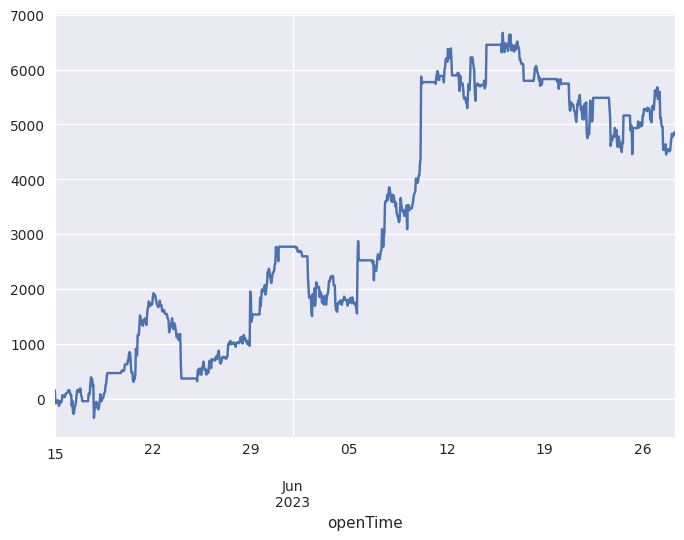

In [131]:
result.sum(axis = 1).loc[datetime(2023,5,15):].cumsum().plot()


In [50]:
import glob

In [76]:
data = []
for File in glob.glob('/home/frank/qt_output/2023_06_28_12_40_36/nav_dataframe/*.csv'):
    # print(File)
    df = pd.read_csv(File,index_col = 0)
    df.index = pd.to_datetime(df.index)
    data.append(df.diff())
    # break
# pd.concat(data,axis = 0).fillna(0)


In [77]:
data2 = []
for File in glob.glob('/home/frank/qt_output/2023_06_28_15_11_57/nav_dataframe/*.csv'):
    # print(File)
    df = pd.read_csv(File,index_col = 0)
    df.index = pd.to_datetime(df.index)
    data2.append(df.diff())

    # break


In [88]:
compare = pd.concat(data2,axis = 1) - pd.concat(data,axis = 1)
compare = compare.loc[datetime(2022,1,1):].round(6)
compare[compare != 0].stack().abs().sort_values()


timestamp                                 
2022-01-01 02:00:00  z02_integral_avax_60m    0.000001
2022-11-09 04:00:00  z02_integral_avax_60m    0.000001
2022-11-09 09:00:00  z02_integral_avax_60m    0.000001
2022-11-09 10:00:00  z02_integral_avax_60m    0.000001
2022-11-09 11:00:00  z02_integral_avax_60m    0.000001
                                                ...   
2022-01-22 06:00:00  z02_integral_bnb_60m     0.001981
2022-01-21 02:00:00  z02_integral_bnb_60m     0.002400
2023-06-14 21:00:00  z02_integral_avax_60m    0.003036
2022-01-21 22:00:00  z02_integral_bnb_60m     0.003087
2023-06-10 05:00:00  z02_integral_avax_60m    0.011004
Length: 5211, dtype: float64

In [104]:
compare[compare != 0].stack().reset_index()['level_1'].unique()

array(['z02_integral_avax_60m', 'z02_integral_fil_60m',
       'z02_integral_bnb_60m', 'kc_volatility_v3_t3_crv_60m'],
      dtype=object)

<AxesSubplot:title={'center':'z02_integral_avax_60m'}, xlabel='timestamp'>

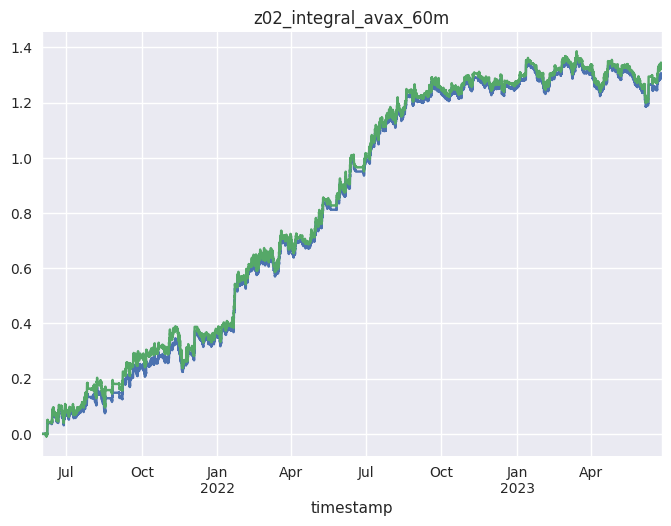

In [117]:
strategy = compare[compare != 0].stack().reset_index()['level_1'].unique()[0]
pd.concat(data2,axis = 1)[strategy].loc[datetime(2021,6,1):].cumsum().plot(title=  strategy)
pd.concat(data,axis = 1)[strategy].loc[datetime(2021,6,1):].cumsum().plot(title = strategy)
    

<AxesSubplot:xlabel='openTime'>

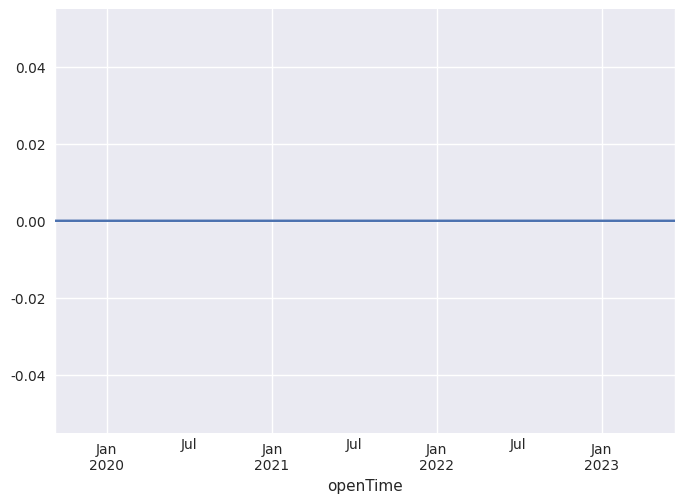

In [73]:
# result.sum(axis = 1).cumsum().plot()
long_result.sum(axis = 1).cumsum().plot()

In [36]:
df = pd.DataFrame(param_result).T#.cumsum().plot()
df['Ann. Sharpe']

8      0.255230
24    -0.707157
72     0.963200
168    0.050017
Name: Ann. Sharpe, dtype: float64

<AxesSubplot:xlabel='openTime'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


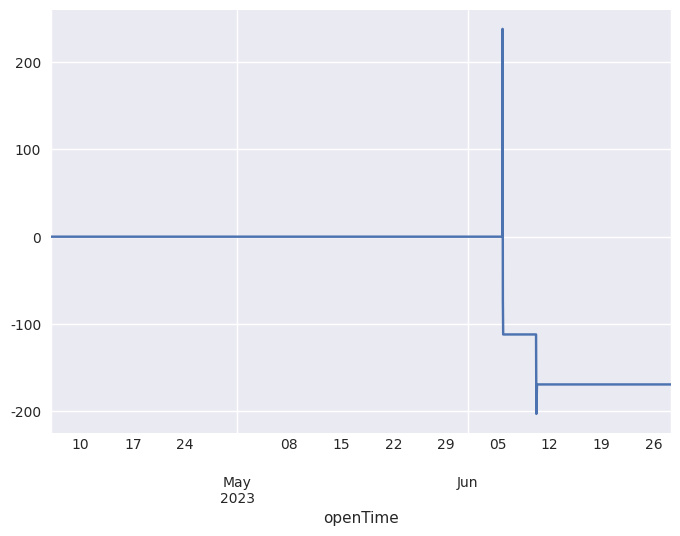

In [18]:
long_signal = signal[signal>0].fillna(0)

size = long_signal.copy()
size = 1/df_data['Close'].div((10**4/long_signal.abs().sum(axis = 1)),axis = 0).replace([np.inf,-np.inf],0)
size = size.ffill().fillna(0).replace([np.inf,-np.inf],0) * long_signal
# size = size[signal!=signal.shift(1)].ffill().fillna(0).replace([np.inf,-np.inf],0) * signal



FEE = 0

cost = size.diff().abs() * df_data['Close'] * FEE *10**-4

result = size.shift(1) * df_data['Close'].diff() - cost

result.sum(axis = 1).cumsum().plot()


0.4454545113591212

<AxesSubplot:xlabel='openTime'>

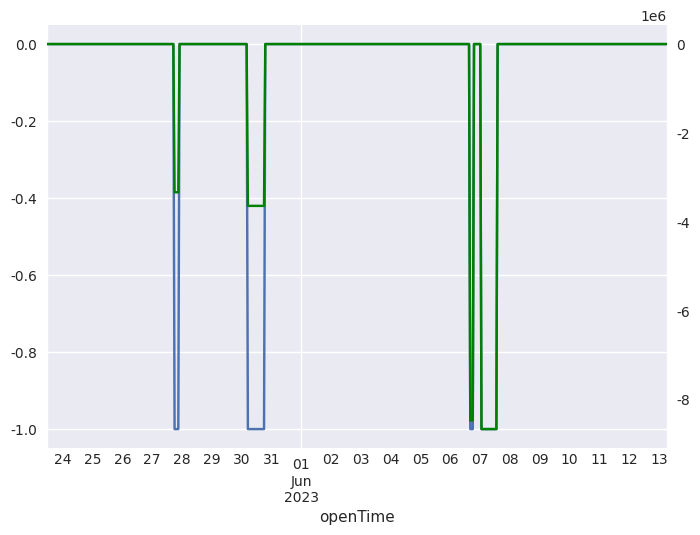

In [192]:
ax2 = signal['1000pepeusdt'].tail(500).plot().twinx()
size['1000pepeusdt'].tail(500).fillna(0).plot(ax = ax2,c = 'g',grid = False)

<AxesSubplot:xlabel='openTime'>

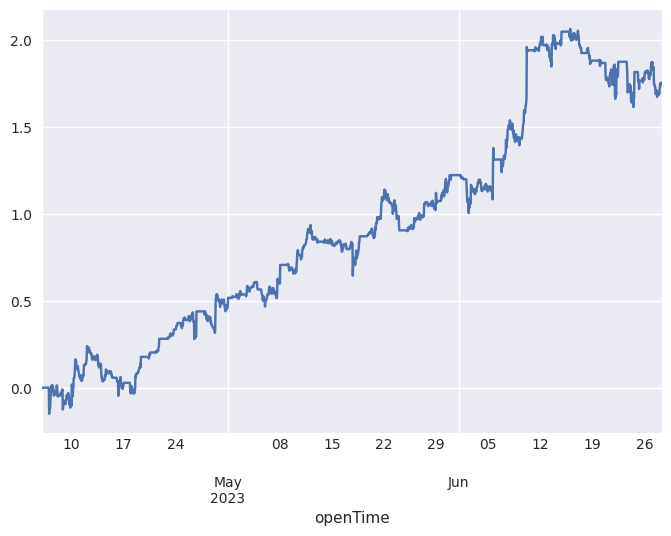

In [19]:
(signal.shift(1) * df_data['Close'].pct_change()).sum(axis = 1).cumsum().plot()

In [143]:
cost.sum(axis = 1)

openTime
2019-09-08 17:00:00    0.000000
2019-09-08 18:00:00    0.000000
2019-09-08 19:00:00    0.000000
2019-09-08 20:00:00    0.000000
2019-09-08 21:00:00    0.000000
                         ...   
2023-06-13 02:00:00    0.000000
2023-06-13 03:00:00    0.028376
2023-06-13 04:00:00    8.130193
2023-06-13 05:00:00    0.123117
2023-06-13 06:00:00    0.139771
Freq: H, Length: 32966, dtype: float64

In [136]:
(size * df_data['Close']).abs().sum(axis = 1).value_counts()

0.0        21773
10000.0     9222
10000.0     1011
10000.0      960
dtype: int64

In [122]:
size = signal.copy()
size[:] = 0
# size = signal/df_data['Close'].div(10**4 / signal.abs().sum(axis = 1),axis = 0)
# signal/df_data['Close']
# 10**4/signal.abs().sum(axis = 1)#
# df_data['Close']#.div((10**4/signal.abs().sum(axis = 1)).replace([np.inf,-np.inf],0),axis = 0)
size = 1/df_data['Close'].div((10**4/signal.abs().sum(axis = 1)),axis = 0).replace([np.inf,-np.inf],0)
size = size[signal != signal.shift(1)]
size = size.ffill() * signal

In [113]:
df_data['Close'].tail(3)

symbol,1000bttcusdt,1000flokiusdt,1000luncusdt,1000pepeusdt,1000shibusdt,1000xecusdt,1inchusdt,aaveusdt,achusdt,adausdt,...,xmrusdt,xrpusdt,xtzusdt,xvsusdt,yfiiusdt,yfiusdt,zecusdt,zenusdt,zilusdt,zrxusdt
openTime,,,,,,,,,,,,,,,,,,,,,
2023-06-13 04:00:00,NaN,0.02182,0.09341,0.000915,0.006732,0.02023,0.2715,53.99,0.02027,0.2767,...,139.35,0.5286,0.739,3.444,NaN,5572.0,25.42,6.179,0.01763,0.1748
2023-06-13 05:00:00,NaN,0.02222,0.09231,0.000920,0.006733,0.02025,0.2713,54.10,0.02031,0.2787,...,138.86,0.5298,0.736,3.434,NaN,5607.0,25.51,6.234,0.01769,0.1752
2023-06-13 06:00:00,NaN,0.02228,0.09223,0.000923,0.006722,0.02030,0.2728,54.22,0.02036,0.2799,...,138.43,0.5295,0.737,3.430,NaN,5607.0,25.61,6.244,0.01771,0.1752


In [92]:
print(json.dumps(size.iloc[-1].to_dict(),indent=4))

{
    "1000bttcusdt": 0.0,
    "1000flokiusdt": 0.0,
    "1000luncusdt": 0.0,
    "1000pepeusdt": 0.0,
    "1000shibusdt": 0.0,
    "1000xecusdt": 0.0,
    "1inchusdt": 0.0,
    "aaveusdt": 0.0,
    "achusdt": 0.0,
    "adausdt": 0.0,
    "agixusdt": 0.0,
    "akrousdt": 0.0,
    "algousdt": 0.0,
    "aliceusdt": 0.0,
    "alphausdt": 0.0,
    "ambusdt": 0.0,
    "ancusdt": 0.0,
    "ankrusdt": 0.0,
    "antusdt": 0.0,
    "apeusdt": 0.0,
    "api3usdt": 0.0,
    "aptusdt": 0.0,
    "arbusdt": 0.0,
    "arpausdt": 0.0,
    "arusdt": 0.0,
    "astrusdt": 0.0,
    "atausdt": 0.0,
    "atomusdt": 0.0,
    "audiousdt": 0.0,
    "avaxusdt": 0.0,
    "axsusdt": 0.0,
    "bakeusdt": 0.0,
    "balusdt": 0.0,
    "bandusdt": 0.0,
    "batusdt": 0.0,
    "bchusdt": 0.0,
    "belusdt": 0.0,
    "bluebirdusdt": 0.0,
    "blurusdt": 0.0,
    "blzusdt": 0.0,
    "bnbusdt": 0.0,
    "bnxusdt": 0.0,
    "btcdomusdt": 0.0,
    "btcstusdt": 0.0,
    "btcusdt": 0.0,
    "btsusdt": 0.0,
    "bttusdt": 0.0

In [22]:
df_data['Close']

symbol,1000bttcusdt,1000flokiusdt,1000luncusdt,1000pepeusdt,1000shibusdt,1000xecusdt,1inchusdt,aaveusdt,achusdt,adausdt,...,xmrusdt,xrpusdt,xtzusdt,xvsusdt,yfiiusdt,yfiusdt,zecusdt,zenusdt,zilusdt,zrxusdt
openTime,,,,,,,,,,,,,,,,,,,,,
2019-09-08 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13 02:00:00,NaN,0.02180,0.09315,0.000924,0.006694,0.02023,0.2721,54.12,0.02033,0.2795,...,139.22,0.5253,0.746,3.506,NaN,5608.0,25.47,6.206,0.01767,0.1740
2023-06-13 03:00:00,NaN,0.02172,0.09486,0.000921,0.006721,0.02024,0.2723,53.99,0.02025,0.2777,...,139.48,0.5258,0.741,3.478,NaN,5598.0,25.40,6.201,0.01774,0.1750
2023-06-13 04:00:00,NaN,0.02182,0.09341,0.000915,0.006732,0.02023,0.2715,53.99,0.02027,0.2767,...,139.35,0.5286,0.739,3.444,NaN,5572.0,25.42,6.179,0.01763,0.1748


In [36]:
tmp = signal.iloc[-20].copy()
tmp[tmp!=0]

symbol
jasmyusdt    1.0
Name: 2023-05-06 00:00:00, dtype: float64

In [3]:
from util.crawl import *
from util.backtest import *
from util.factor_util import *
import tqdm

url = 'https://api.tardis.dev/v1/exchanges/binance-futures'
result = requests.get(url).json()
result['availableSymbols']
perpetual_symbols = [sym['id'][:-4] for sym in result['availableSymbols'] if 'usdt' in sym['id'] and sym['type']=='perpetual']


symbol_data = []

for sym in tqdm.tqdm(perpetual_symbols):
    # print(sym)
    try:
        tmp = crawl_binance_futures(sym.upper(),start=int(datetime.now().timestamp() - 2000*3600)*1000,freq='1h')
        tmp['symbol'] = sym
        # symbol_close[sym] = crawl_binance_futures(sym[:-4],start=int(datetime.now().timestamp() - 24*60*60*30)*1000,freq='1h')#.Close
        symbol_data.append(tmp)
    except Exception as e:
        print(sym,e)
symbol_data = pd.concat(symbol_data)


 94%|█████████▍| 195/207 [04:30<00:10,  1.20it/s]

akro No objects to concatenate


 95%|█████████▍| 196/207 [04:31<00:08,  1.25it/s]

dodo No objects to concatenate


 95%|█████████▌| 197/207 [04:31<00:06,  1.49it/s]

anc No objects to concatenate


 96%|█████████▌| 198/207 [04:32<00:05,  1.70it/s]

luna No objects to concatenate


 96%|█████████▌| 199/207 [04:32<00:04,  1.90it/s]

yfii No objects to concatenate


 97%|█████████▋| 200/207 [04:33<00:03,  2.08it/s]

1000bttc No objects to concatenate


 97%|█████████▋| 201/207 [04:33<00:02,  2.24it/s]

keep No objects to concatenate


 98%|█████████▊| 202/207 [04:33<00:02,  2.34it/s]

nu No objects to concatenate


 98%|█████████▊| 203/207 [04:34<00:01,  2.45it/s]

btt No objects to concatenate


 99%|█████████▊| 204/207 [04:34<00:01,  2.50it/s]

bzrx No objects to concatenate


100%|█████████▉| 206/207 [04:35<00:00,  1.93it/s]

doteco No objects to concatenate


100%|██████████| 207/207 [04:36<00:00,  1.33s/it]

lend No objects to concatenate


In [251]:
name = 'Close/Open.Kurt'
name = 'Close.Pct_Change'
# name = 'Open/Close.SignedPower.Kurt'

FREQ = 'D'

stress_score = {}

category = 'all'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])

market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(168).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample(FREQ).last()
cond = GLOBAL_FILTER


print(name)
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor = calc_factors(calc_input_data(df_data,data),formula,params = [168,424,168])#[168,72,208,528]

factor = factor.sort_index().resample(FREQ).last()[cond]

rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')
zscore = factor.add(-factor.mean(axis = 1),axis = 0).div(factor.std(axis = 1),axis = 0)


Close.Pct_Change


In [364]:
total_size = 10**4 / signal.abs().sum(axis = 1)
size = signal/df_data['Close'].resample(FREQ).last().div(total_size,axis = 0)
size = size.shift(1).reindex(df_data['Close'].index).ffill().fillna(0)


new_size = size.copy()
total_size = total_size.shift(1).reindex(df_data['Close'].index).ffill().fillna(0)

value = size * df_data['Close']
threshold = 0.02
for i in range(size.shape[0])[:]:
    curr_profit = value[value!=0].iloc[i].abs() / total_size.iloc[i] - 1

    diff_size = np.floor(curr_profit[curr_profit>0]/threshold) *total_size.iloc[i]  / df_data['Close'].iloc[i]


    new_size.iloc[i] -= diff_size.fillna(0)

    # if (diff_size.fillna(0) != 0).sum() >0 :
    #     break

    # break

<AxesSubplot:xlabel='openTime'>

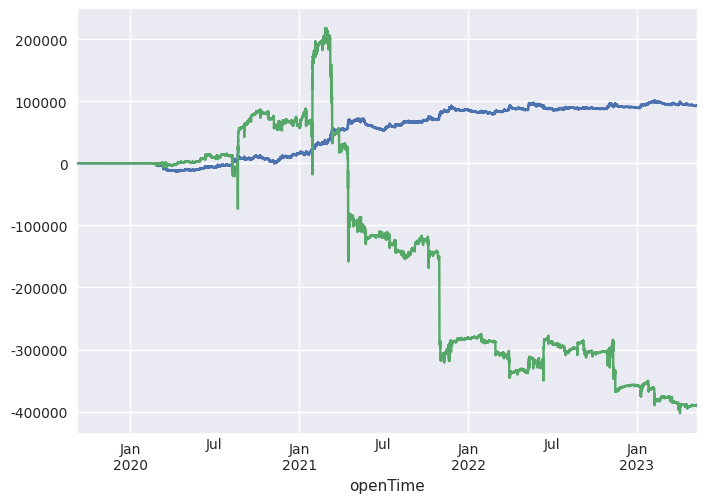

In [367]:
(size.shift(1) * df_data['Close'].diff())[:].sum(axis = 1).cumsum().plot()
(new_size.shift(1) * df_data['Close'].diff())[:].sum(axis = 1).cumsum().plot()

In [343]:
compare = size.iloc[i] - new_size.iloc[i]
(compare[compare != 0] * df_data['Close'].iloc[i] ).dropna()
total_size.iloc[i]
# signal.abs().sum(axis = 1).iloc[i]

2000.0

In [347]:
curr_profit.dropna()

symbol
belusdt      0.012287
cocosusdt    0.029043
idusdt       0.014906
trxusdt     -0.008701
zilusdt     -0.045342
Name: 2023-04-24 15:00:00, dtype: float64

In [300]:
np.floor(0.189 / 0.1)/1.319

0.7581501137225171

In [294]:
curr_profit.dropna() / 0.1


symbol
belusdt      0.122871
cocosusdt    0.290433
idusdt       0.149055
trxusdt     -0.087009
zilusdt     -0.453416
Name: 2023-04-24 15:00:00, dtype: float64

In [287]:
threshold

0.1

In [245]:
# size = signal/df_data['Close'].resample(FREQ).last().div(size,axis = 0)
total_size = 10**4 / ((zscore>2) | (zscore<-2)).sum(axis = 1)


size.loc[ix] = total_size.loc[ix] * (zscore.loc[ix] >2) / df_data['Close'].loc[ix]
total_size
size.loc[ix].sum()


43160.705260995346

In [246]:
total_size.loc[ix]
zscore.tail(1)

symbol,1000bttcusdt,1000flokiusdt,1000luncusdt,1000pepeusdt,1000shibusdt,1000xecusdt,1inchusdt,aaveusdt,achusdt,adausdt,...,xmrusdt,xrpusdt,xtzusdt,xvsusdt,yfiiusdt,yfiusdt,zecusdt,zenusdt,zilusdt,zrxusdt
openTime,,,,,,,,,,,,,,,,,,,,,
2023-05-11 06:00:00,NaN,NaN,-0.284337,NaN,0.145242,NaN,NaN,0.223577,NaN,0.650282,...,1.305264,0.592499,NaN,NaN,NaN,NaN,0.177136,NaN,NaN,NaN


In [233]:
size = zscore.copy()
size[:] = np.nan


total_size = 10**4 / ((zscore.loc[ix]>2) | (zscore.loc[ix]<-2)).sum()
# total_size

size.loc[ix][(zscore.loc[ix]>2)] = (zscore.loc[ix]>2) * total_size
size.loc[ix][(zscore.loc[ix]<-2)] = (zscore.loc[ix]<-2) * total_size


#name = 'Close/Open.Kurt'
name = 'Close.Pct_Change'
# name = 'Open/Close.SignedPower.Kurt'

FREQ = 'D'

stress_score = {}

category = 'all'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])

market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(168).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample(FREQ).last()
cond = GLOBAL_FILTER


print(name)
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor = calc_factors(calc_input_data(df_data,data),formula,params = [168,424,168])#[168,72,208,528]

factor = factor.sort_index().resample(FREQ).last()[cond]

rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')
zscore = factor.add(-factor.mean(axis = 1),axis = 0).div(factor.std(axis = 1),axis = 0)

signal = rk.copy()
signal[:] = 0


signal[(zscore>2)] = 1
signal[(zscore<-2)] = -1

size = 10**4 / signal.abs().sum(axis = 1)
size = signal/df_data['Close'].resample(FREQ).last().div(size,axis = 0)
size = size.shift(1).reindex(df_data['Close'].index).ffill().fillna(0)


FEE = 0

cost = size.diff().abs() * df_data['Close'] * FEE *10**-4

result = size * df_data['Close'].diff() #- cost

result.sum(axis = 1).cumsum().plot()
# name = 'Close/Open.Kurt'
name = 'Close.Pct_Change'
# name = 'Open/Close.SignedPower.Kurt'

FREQ = 'D'

stress_score = {}

category = 'all'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])

market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(168).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample(FREQ).last()
cond = GLOBAL_FILTER


print(name)
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor = calc_factors(calc_input_data(df_data,data),formula,params = [168,424,168])#[168,72,208,528]

factor = factor.sort_index().resample(FREQ).last()[cond]

rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')
zscore = factor.add(-factor.mean(axis = 1),axis = 0).div(factor.std(axis = 1),axis = 0)

signal = rk.copy()
signal[:] = 0


signal[(zscore>2)] = 1
signal[(zscore<-2)] = -1

size = 10**4 / signal.abs().sum(axis = 1)
size = signal/df_data['Close'].resample(FREQ).last().div(size,axis = 0)
size = size.shift(1).reindex(df_data['Close'].index).ffill().fillna(0)


FEE = 0

cost = size.diff().abs() * df_data['Close'] * FEE *10**-4

result = size * df_data['Close'].diff() #- cost

result.sum(axis = 1).cumsum().plot()
# 
size.loc[ix] = size.loc[ix]/df_data['Close'].loc[ix]
size.loc[ix].sum()

46057.9962938796

<AxesSubplot:xlabel='openTime'>

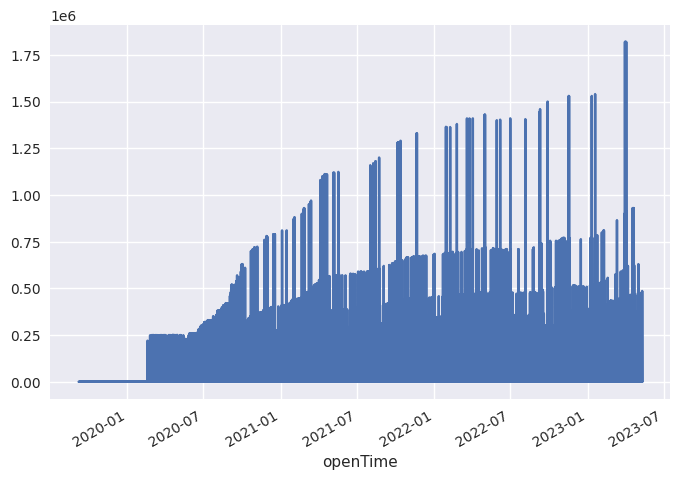

In [165]:
(size * df_data['Close']).add( 10**4 / signal.abs().sum(axis = 1),axis = 0).sum(axis = 1).plot()

Close.Pct_Change


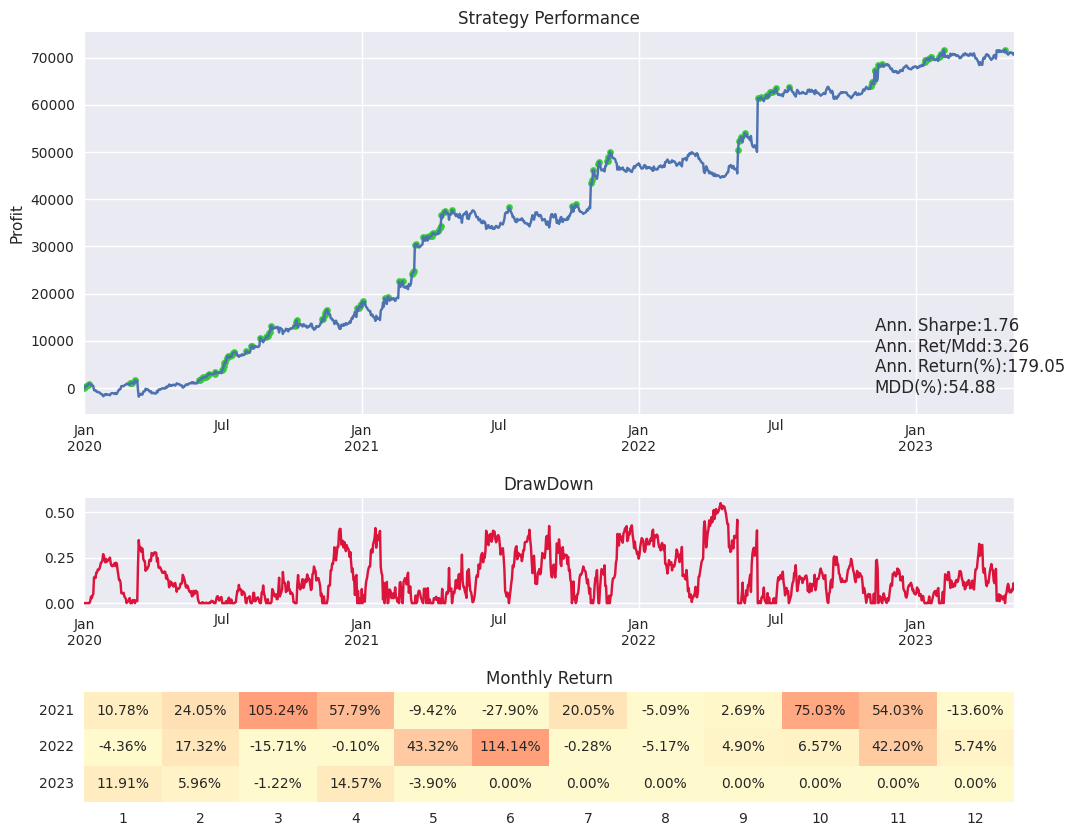

In [20]:
name = 'BuyerRatio*Low/Open.Rank.Quantile25.Means'#metrics.index[400]
# name = 'Open/Close.Abs.Kurt_Reverse'
# name = 'BuyerRatio*Open/Close.Pct_Change.SignedPower.Quantile25'#24,152,192
# name = 'Low/Close.SignedPower.SignedPower.Skew'
name = 'Low/High.Std.Skew.Skew_Reverse'
# name = 'BuyerRatio*Low/High.Rank.Skew.Max_Reverse'#72,136
# # name = 'Open/Close.SignedPower.Kurt.Abs_Reverse'#72,456
# name = 'Open/Close.Kurt.Abs_Reverse'#72,160
# name = 'quoteAssetVolume*Close/Open.Max.Pct_Change.Skew_Reverse'#"24,480,288,312"
# name = 'quoteAssetVolume*Low/High.Skew.Quantile25.Quantile25_Reverse'
# name = 'Close/High.Skew'#168,152
# name = 'Low/Close.Skew.Abs.Pct_Change_Reverse'
# name = 'Open/Close.Std.Kurt.Std_Reverse'#720,168,144,264
name = 'Open/Close.SignedPower.Abs.Kurt_Reverse'
# name = 'BuyerRatio*Open/High.Mean.Pct_Change.Min'
name = 'Close.Pct_Change'
# name = 'Close.Rank'
# name = 'High/Low.Std.SignedPower.Skew_Reverse'#720,168,144,264

# name = 'BuyerRatio.Pct_Change.Quantile25.Pct_Change_Reverse'
# name = 'Low/High.Kurt.Skew.Skew_Reverse'
# name = 'Low/High.SignedPower.Std.Skew_Reverse'
# name = 'BuyerRatio*Low/High.Pct_Change.Mean.Min'
# name = "BuyerRatio.Rank.Abs.Mean"

stress_score = {}

category = 'all'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])

market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(168).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()


print(name)
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor = calc_factors(calc_input_data(df_data,data),formula,params = [168,424,168])#[168,72,208,528]

factor = factor.sort_index().resample(FREQ).last()
cond = GLOBAL_FILTER


for selected in [5,10,20]:
    selected = 5


    select = cond.sum(axis = 1) * selected * 0.01
    select = select.apply(lambda x:max(np.floor(x),3))

    rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')

    long_signal = rk.copy()
    long_signal[:] = 0
    short_signal = long_signal.copy()

    long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) & (df_data['Close'].pct_change()>0)] = 1 
    short_signal[rk.le(select,axis = 0) & (df_data['Close'].pct_change()<0)] = -1 

    # long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) ] = 1 
    # short_signal[rk.le(select,axis = 0) ] = -1 

    # rk = factor[cond].rank(axis = 1,pct=True,method = 'dense',ascending = False)

    # rk = factor[cond].rank(axis = 1,method = 'dense',ascending = '_Reverse' not in name)
    # rk = rk.add(-rk.mean(axis = 1),axis= 0)
    # long_signal = rk.copy()
    # short_signal = rk.copy()
    # long_signal[rk<0] = 0
    # short_signal[rk>0] = 0

    # if '_Reverse' in name:
    #     long_signal *= -1
    #     short_signal *= -1

    FEE = 0
    long_result = fast_backtest(ret,long_signal,fee = FEE)#.sum(axis = 1)
    short_result = fast_backtest(ret,short_signal,fee = FEE)#.sum(axis = 1)

    result = ((long_result + short_result)/2).sum(axis = 1)
    # long_result = long_result.sum(axis = 1)
    # short_result = short_result.sum(axis = 1)

    # result[result>result[result != 0].quantile(0.99)] = 0

    show_return(result.loc[datetime(2020,1,1):],figsize= (12,10))
    score = show_performance_metrics(result.loc[datetime(2020,1,1):],show = False)['FitnessValue']
    # stress_score.append(score)
    stress_score[selected] = result.loc[datetime(2021,1,1):]#SAMPLE_END_DATE
    
    break
# stress_score
# pd.DataFrame(stress_score).loc[datetime(2021,1,1):SAMPLE_END_DATE].cumsum().plot(title=name)
# stress_score = pd.DataFrame(stress_score).sum(axis = 1)

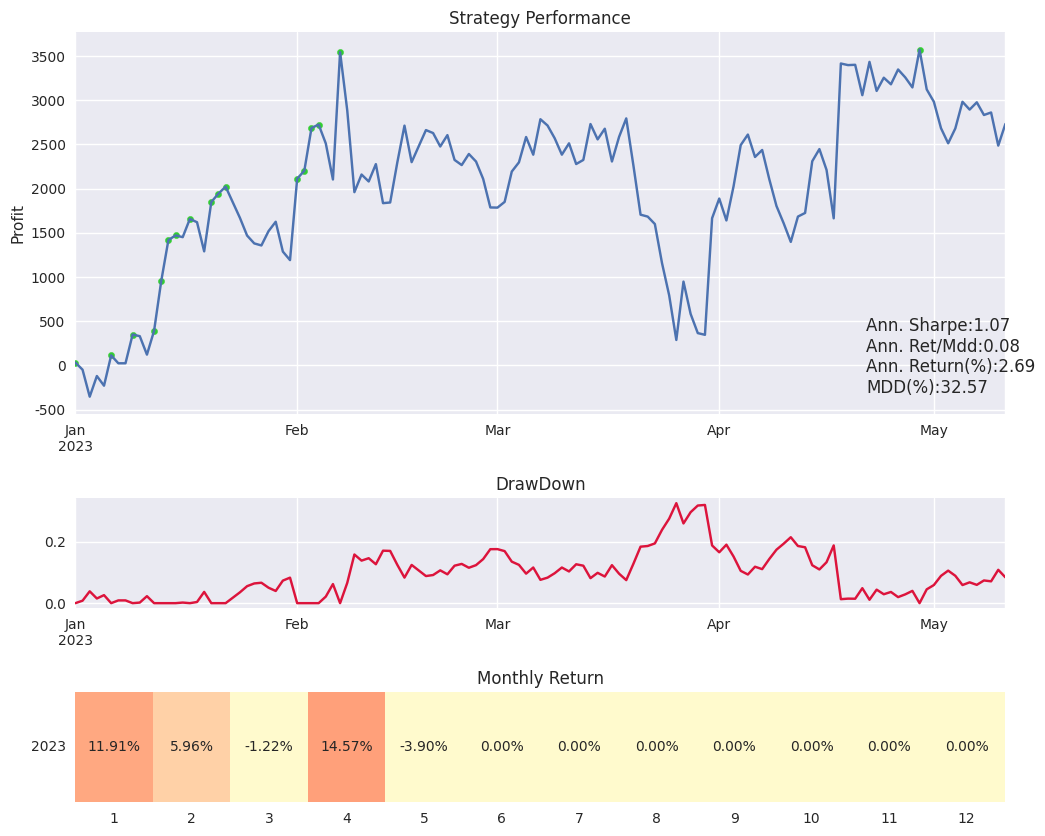

In [27]:
show_return(result.loc[datetime(2023,1,1):],figsize= (12,10))


In [76]:
result = long_result.sum(axis = 1) + short_result.sum(axis = 1) *beta
show_performance_metrics(result.loc[datetime(2020,1,1):],show = False)#['Shar[e']

{'Ann. Return(%)': 174.6882622906401,
 'MDD(%)': 71.53311980753139,
 'Ret/Mdd': 2.4420612823914323,
 'Ann. Sharpe': 2.1719296937771904,
 'ATH_Score': 0.15699100572363042,
 'Monthly_Return_Score': 0.7804878048780488,
 'Cummax_Score': 0.3296753246753247,
 'FitnessValue': 1.310687029580035}

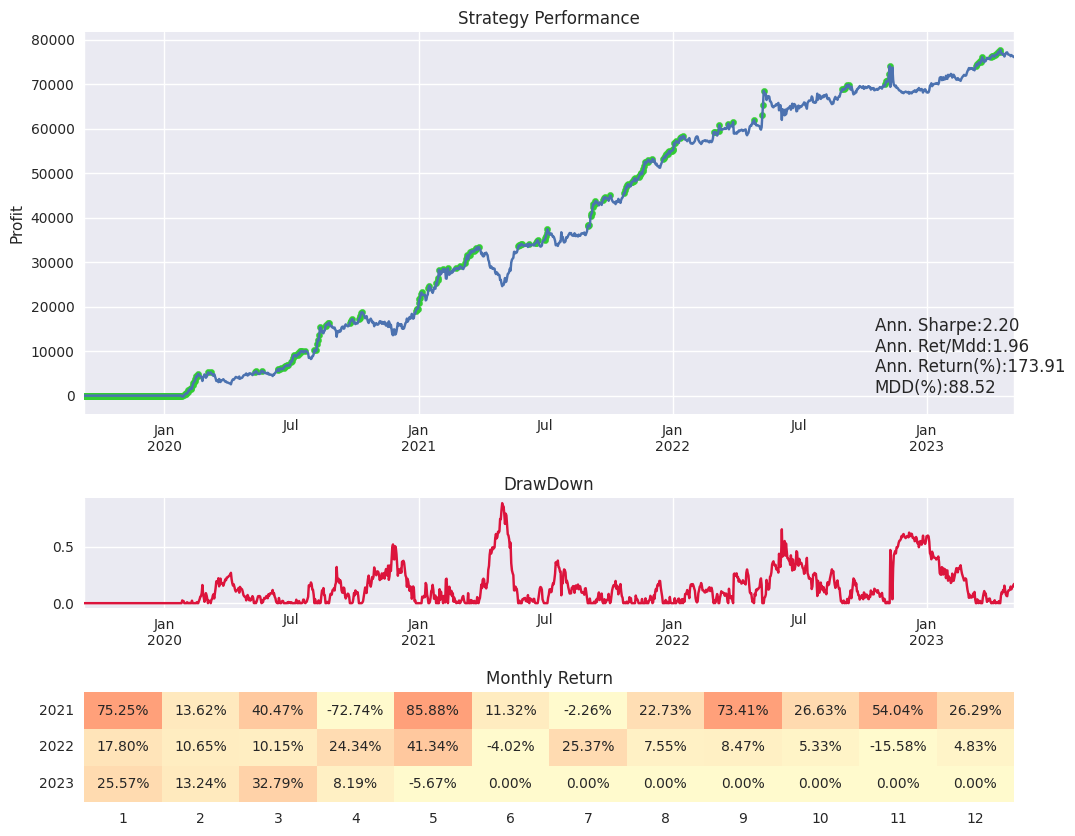

In [77]:
show_return(long_result.sum(axis = 1) + short_result.sum(axis = 1) ,figsize= (12,10))

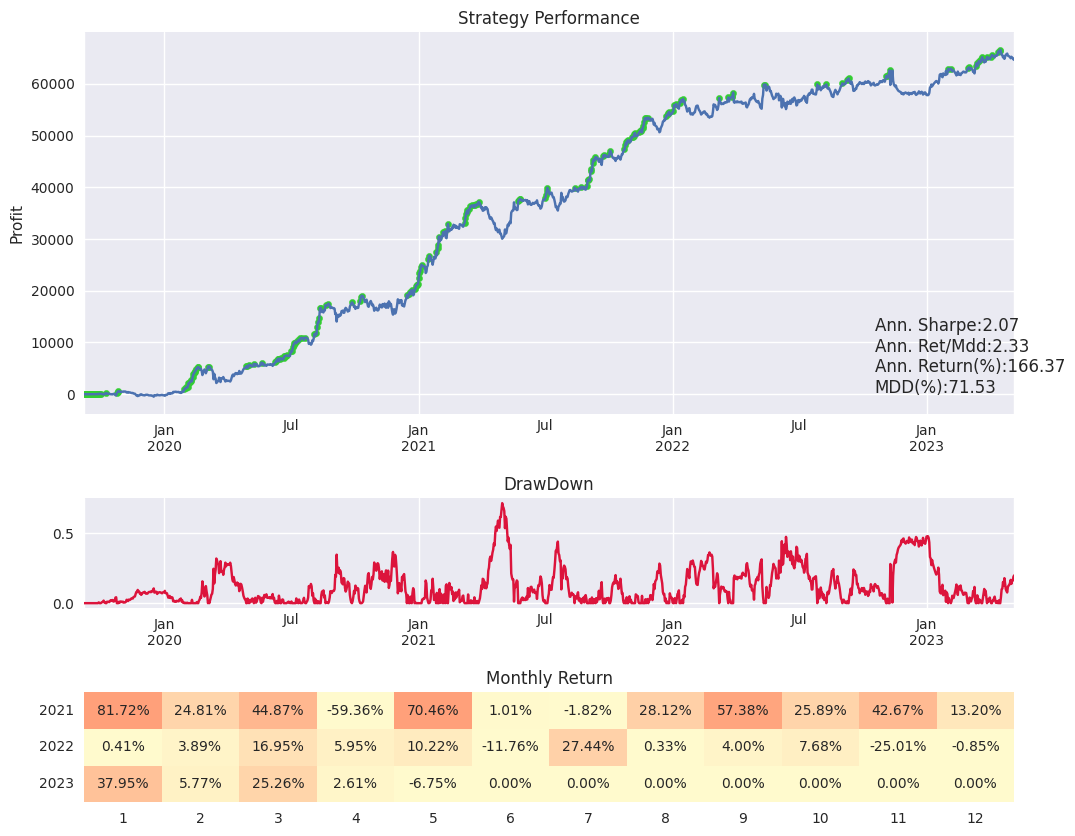

In [73]:
show_return(long_result.sum(axis = 1) + short_result.sum(axis = 1)*beta ,figsize= (12,10))

<AxesSubplot:xlabel='DateTime'>

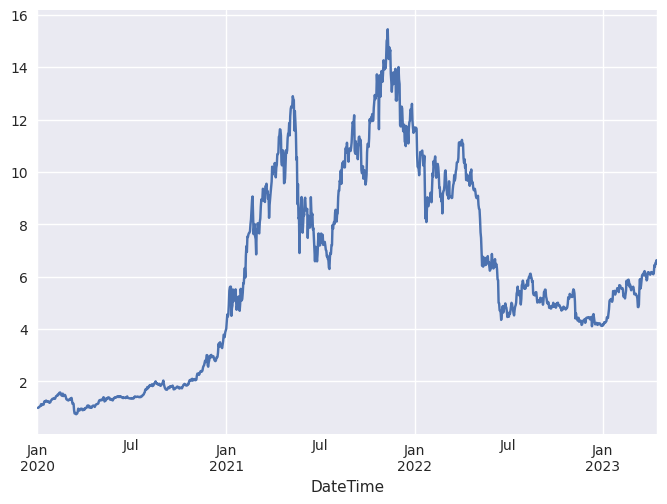

In [16]:
BM = crawl_cmcIndex()['CryptoMarket']
BM = BM.loc[datetime(2020,1,1):df_data['Close'].index[-1]]
BM = BM.pct_change()
BM.add(1).cumprod().plot()

<AxesSubplot:xlabel='openTime'>

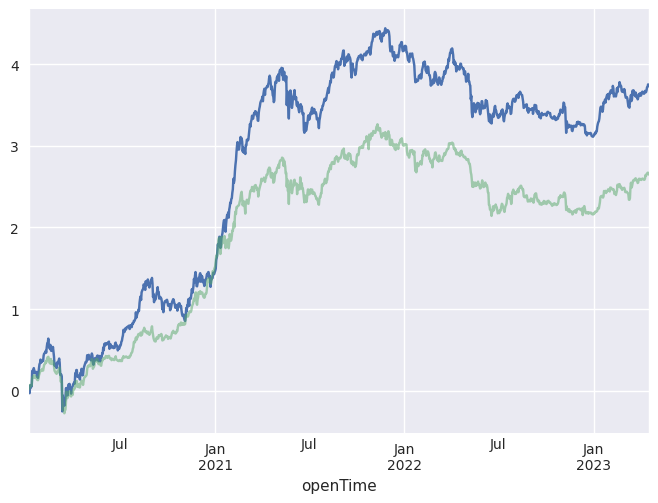

In [17]:
rk = factor.rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense',pct = True)
rk = rk[~(rk.isna().all(axis = 1))]
rk = rk.div(rk.sum(axis = 1),axis = 0)
perform = (rk.shift(1)*ret.loc[rk.index]).sum(axis = 1).loc[:]
# perform = fast_backtest(ret,long_signal,fee = 0).sum(axis = 1)
perform.cumsum().plot()
bm = BM.copy()
bm = BM.loc[perform.index]
bm.cumsum().plot(alpha = 0.5)

In [19]:
beta = perform.cov(bm)/perform.var()
np.sqrt(perform.var() - bm.var()* (beta ** 2))
# beta

0.047360310259365095

<AxesSubplot:xlabel='openTime'>

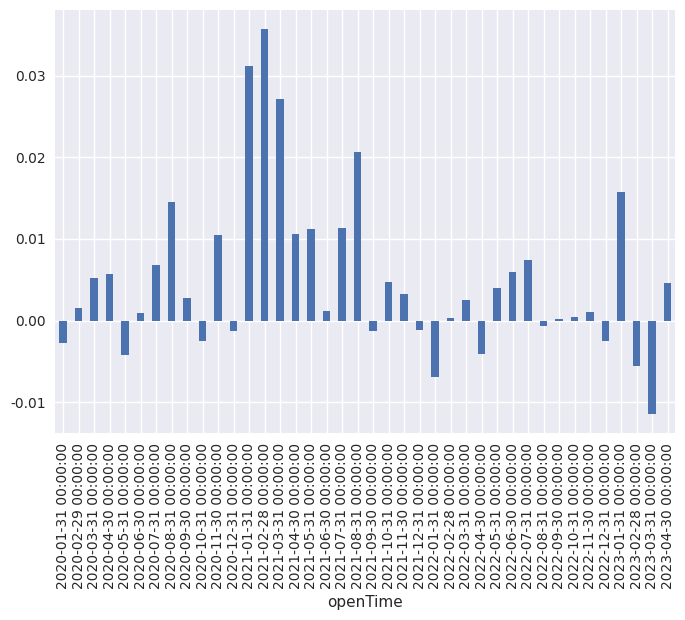

In [20]:
(perform - beta * bm).resample('M').quantile(0.5).plot.bar()

In [9]:
show_performance_metrics(result,show = False)
result.shape[0]

1204

In [10]:
result1 = result.copy()

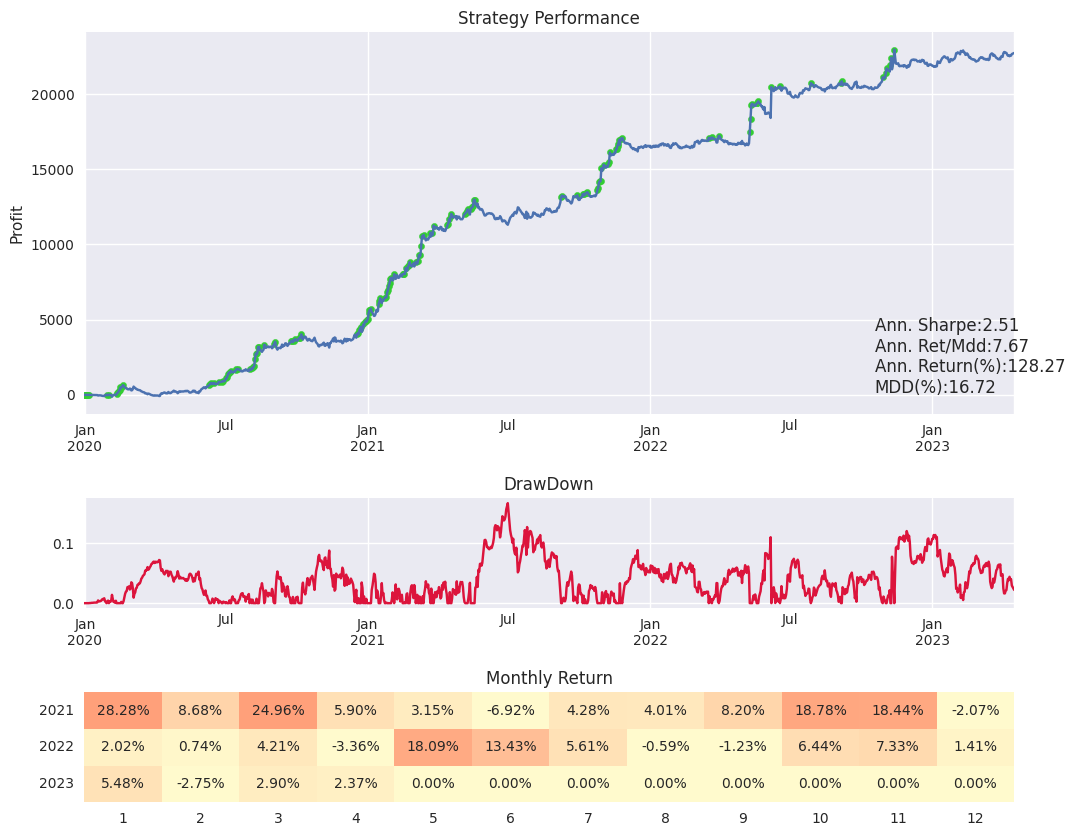

In [12]:
name = 'BuyerRatio*Low/Open.Rank.Quantile25.Means'#metrics.index[400]
# name = 'Open/Close.Abs.Kurt_Reverse'
# name = 'BuyerRatio*Open/Close.Pct_Change.SignedPower.Quantile25'#24,152,192
# name = 'Low/Close.SignedPower.SignedPower.Skew'
name = 'Low/High.Std.Skew.Skew_Reverse'
# name = 'BuyerRatio*Low/High.Rank.Skew.Max_Reverse'#72,136
# # name = 'Open/Close.SignedPower.Kurt.Abs_Reverse'#72,456
# name = 'Open/Close.Kurt.Abs_Reverse'#72,160
# name = 'quoteAssetVolume*Close/Open.Max.Pct_Change.Skew_Reverse'#"24,480,288,312"
# name = 'quoteAssetVolume*Low/High.Skew.Quantile25.Quantile25_Reverse'
# name = 'Close/High.Skew'#168,152
# name = 'Low/Close.Skew.Abs.Pct_Change_Reverse'
# name = 'Open/Close.Std.Kurt.Std_Reverse'#720,168,144,264
name = 'Open/Close.SignedPower.Abs.Kurt_Reverse'
# name = 'BuyerRatio*Open/High.Mean.Pct_Change.Min'
name = 'Close.Pct_Change'
# name = 'Close.Rank'
# name = 'High/Low.Std.SignedPower.Skew_Reverse'#720,168,144,264

# name = 'BuyerRatio.Pct_Change.Quantile25.Pct_Change_Reverse'
# name = 'Low/High.Kurt.Skew.Skew_Reverse'
# name = 'Low/High.SignedPower.Std.Skew_Reverse'
# name = 'BuyerRatio*Low/High.Pct_Change.Mean.Min'
# name = "BuyerRatio.Rank.Abs.Mean"

stress_score = {}

category = 'all'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])

market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(168).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()


print(name)
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor = calc_factors(calc_input_data(df_data,data),formula,params = [168,424,168])#[168,72,208,528]

factor = factor.sort_index().resample(FREQ).last()
cond = GLOBAL_FILTER


for selected in [5,10,20]:
    selected = 5


    select = cond.sum(axis = 1) * selected * 0.01
    select = select.apply(lambda x:max(np.floor(x),3))

    rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')

    long_signal = rk.copy()
    long_signal[:] = 0
    short_signal = long_signal.copy()

    # long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) & (df_data['Close'].pct_change()>0)] = 1 
    # short_signal[rk.le(select,axis = 0) & (df_data['Close'].pct_change()<0)] = -1 

    long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) ] = 1 
    short_signal[rk.le(select,axis = 0) ] = -1 

    # rk = factor[cond].rank(axis = 1,pct=True,method = 'dense',ascending = False)

    # rk = factor[cond].rank(axis = 1,method = 'dense',ascending = '_Reverse' not in name)
    # rk = rk.add(-rk.mean(axis = 1),axis= 0)
    # long_signal = rk.copy()
    # short_signal = rk.copy()
    # long_signal[rk<0] = 0
    # short_signal[rk>0] = 0

    # if '_Reverse' in name:
    #     long_signal *= -1
    #     short_signal *= -1

    FEE = 0
    long_result = fast_backtest(ret,long_signal,fee = FEE)#.sum(axis = 1)
    short_result = fast_backtest(ret,short_signal,fee = FEE)#.sum(axis = 1)

    result = ((long_result + short_result)/2).sum(axis = 1)
    # long_result = long_result.sum(axis = 1)
    # short_result = short_result.sum(axis = 1)

    # result[result>result[result != 0].quantile(0.99)] = 0

    show_return(result.loc[datetime(2020,1,1):],figsize= (12,10))
    score = show_performance_metrics(result.loc[datetime(2020,1,1):],show = False)['FitnessValue']
    # stress_score.append(score)
    stress_score[selected] = result.loc[datetime(2021,1,1):]#SAMPLE_END_DATE
    
    break
# stress_score
# pd.DataFrame(stress_score).loc[datetime(2021,1,1):SAMPLE_END_DATE].cumsum().plot(title=name)
# stress_score = pd.DataFrame(stress_score).sum(axis = 1)

In [15]:
def calc_factors(input_data,formula,params = None):
    operators = formula.split('.')

    if not (params is None):
        params_combination = params
    else:
        params_combination = list(itertools.product([24*7],repeat = len(operators)))[0]

    factor = input_data.copy()
    i = 0
    for operator in operators:
        if operator in FORMULAS_PARAM_FREE:
            factor = calc_operator(factor,operator,0)
        else:        
            print(operator,params_combination[i])

            factor = calc_operator(factor,operator,params_combination[i])
            i += 1

    return factor

In [16]:
xx = calc_input_data(df_data,data)

factor = calc_factors(xx,'SignedPower.Std.Skew',[192,168])#[168,72,208,528]
factor.tail()


Std 192
Skew 168


/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


symbol,1000bttcusdt,1000luncusdt,1000shibusdt,1000xecusdt,1inchusdt,aaveusdt,achusdt,adausdt,agixusdt,akrousdt,...,xlmusdt,xmrusdt,xrpusdt,xtzusdt,yfiiusdt,yfiusdt,zecusdt,zenusdt,zilusdt,zrxusdt
openTime,,,,,,,,,,,,,,,,,,,,,
2023-02-23 03:00:00,NaN,-0.123201,0.299224,0.294789,0.981309,-1.017355,NaN,-0.730222,NaN,NaN,...,0.878943,1.130967,1.116019,1.737456,NaN,0.670392,0.463264,-0.064039,-0.702761,0.788854
2023-02-23 04:00:00,NaN,-0.110648,0.319090,0.288563,0.953464,-0.992814,NaN,-0.744142,NaN,NaN,...,0.897697,1.164228,1.151610,1.711607,NaN,0.698229,0.484007,-0.042339,-0.709039,0.814431
2023-02-23 05:00:00,NaN,-0.098329,0.338983,0.282571,0.926148,-0.968437,NaN,-0.752285,NaN,NaN,...,0.915210,1.197863,1.188049,1.681901,NaN,0.727463,0.504754,-0.020814,-0.717704,0.839520
2023-02-23 06:00:00,NaN,-0.086159,0.358045,0.276653,0.899376,-0.944183,NaN,-0.752389,NaN,NaN,...,0.932819,1.232163,1.225334,1.649821,NaN,0.756802,0.525905,0.000611,-0.727372,0.864595
2023-02-23 07:00:00,NaN,-0.073849,0.378284,0.270462,0.872891,-0.919540,NaN,-0.748256,NaN,NaN,...,0.952474,1.267758,1.263569,1.615801,NaN,0.781070,0.548240,0.022238,-0.736793,0.889343


In [65]:
factor['ethusdt'].sort_values(ascending = False)

openTime
2021-12-04 05:00:00    8.233951
2021-09-07 15:00:00    7.329329
2021-12-04 06:00:00    7.126346
2021-09-07 16:00:00    6.676313
2021-12-04 07:00:00    6.218278
                         ...   
2020-01-15 09:00:00         NaN
2020-01-15 10:00:00         NaN
2020-01-15 11:00:00         NaN
2020-01-15 12:00:00         NaN
2020-01-15 13:00:00         NaN
Name: ethusdt, Length: 27592, dtype: float64

In [72]:
int(0.3/0.2)

1

In [60]:
calc_factors(xx,'SignedPower').rolling(192).std().rolling(168).skew().tail(3)

/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


symbol,1000bttcusdt,1000luncusdt,1000shibusdt,1000xecusdt,1inchusdt,aaveusdt,achusdt,adausdt,agixusdt,akrousdt,...,xlmusdt,xmrusdt,xrpusdt,xtzusdt,yfiiusdt,yfiusdt,zecusdt,zenusdt,zilusdt,zrxusdt
openTime,,,,,,,,,,,,,,,,,,,,,
2023-02-23 05:00:00,NaN,-0.098329,0.338983,0.282571,0.926148,-0.968437,NaN,-0.752285,NaN,NaN,...,0.915210,1.197863,1.188049,1.681901,NaN,0.727463,0.504754,-0.020814,-0.717704,0.839520
2023-02-23 06:00:00,NaN,-0.086159,0.358045,0.276653,0.899376,-0.944183,NaN,-0.752389,NaN,NaN,...,0.932819,1.232163,1.225334,1.649821,NaN,0.756802,0.525905,0.000611,-0.727372,0.864595
2023-02-23 07:00:00,NaN,-0.073849,0.378284,0.270462,0.872891,-0.919540,NaN,-0.748256,NaN,NaN,...,0.952474,1.267758,1.263569,1.615801,NaN,0.781070,0.548240,0.022238,-0.736793,0.889343


In [56]:
rk.max(axis = 1)
cond.sum(axis = 1) - select
# select
# rk.gt(cond.sum(axis = 1) - select,axis = 0)#.sum(axis = 1)


openTime
2019-12-31     0.0
2020-01-01    -1.0
2020-01-02    -1.0
2020-01-03    -1.0
2020-01-04    -1.0
              ... 
2023-02-19    76.0
2023-02-20    76.0
2023-02-21    76.0
2023-02-22    77.0
2023-02-23    77.0
Freq: D, Length: 1151, dtype: float64

<AxesSubplot:xlabel='openTime'>

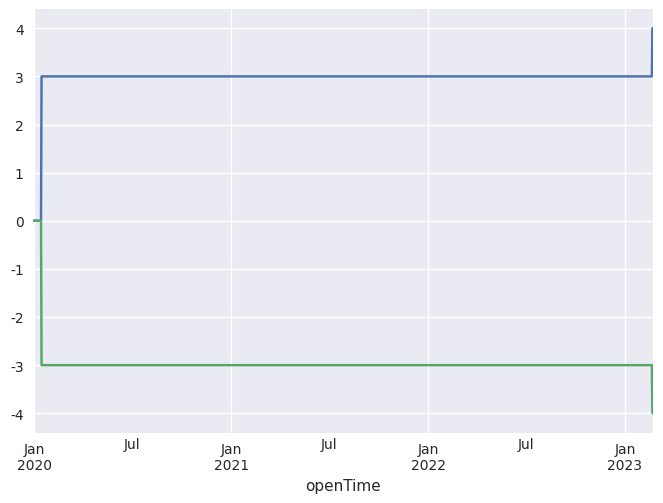

In [59]:
long_signal.sum(axis=  1).plot()
short_signal.sum(axis = 1).plot()

In [26]:
factor[cond].rank(axis = 1,ascending = '_Reverse' in name,method = 'dense')

symbol,bttusdt,btcusdt,ethusdt,bchusdt,xrpusdt,eosusdt,ltcusdt,trxusdt,etcusdt,linkusdt,...,btcstusdt,dotecousdt,lendusdt,agixusdt,phbusdt,gmxusdt,cfxusdt,stxusdt,cocosusdt,achusdt
openTime,,,,,,,,,,,,,,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-19,NaN,35.0,14.0,17.0,21.0,36.0,39.0,53.0,23.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-20,NaN,14.0,7.0,30.0,36.0,23.0,70.0,67.0,24.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-21,NaN,6.0,19.0,54.0,51.0,12.0,71.0,74.0,22.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
factor[cond].rank(axis = 1,ascending = True,method = 'dense').tail()

symbol,bttusdt,btcusdt,ethusdt,bchusdt,xrpusdt,eosusdt,ltcusdt,trxusdt,etcusdt,linkusdt,...,btcstusdt,dotecousdt,lendusdt,agixusdt,phbusdt,gmxusdt,cfxusdt,stxusdt,cocosusdt,achusdt
openTime,,,,,,,,,,,,,,,,,,,,,
2023-02-19,NaN,35.0,14.0,17.0,21.0,36.0,39.0,53.0,23.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-20,NaN,14.0,7.0,30.0,36.0,23.0,70.0,67.0,24.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-21,NaN,6.0,19.0,54.0,51.0,12.0,71.0,74.0,22.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-22,NaN,1.0,6.0,39.0,71.0,8.0,72.0,77.0,27.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-23,NaN,9.0,11.0,37.0,75.0,3.0,72.0,45.0,28.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Open/Close.SignedPower.Kurt.Abs_Reverse


<AxesSubplot:title={'center':'Open/Close.SignedPower.Kurt.Abs_Reverse'}, xlabel='openTime'>

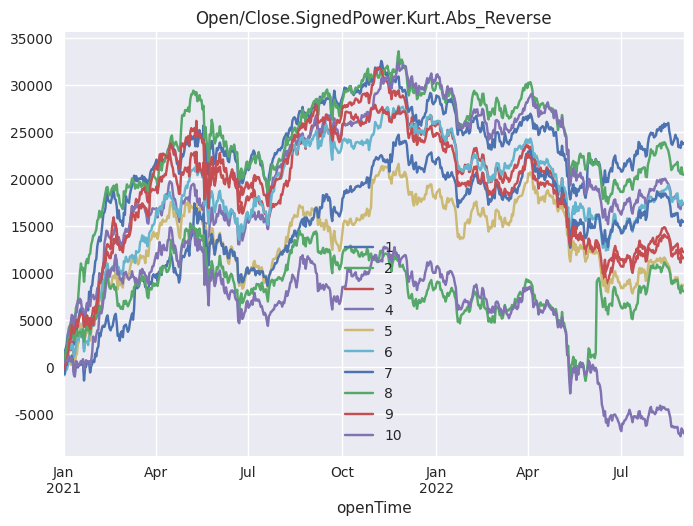

In [12]:
name = 'Open/Close.SignedPower.Kurt.Abs_Reverse'

stress_score = {}

category = 'all'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])

market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(24*7).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter[subset] & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()


print(name)
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor = calc_factors(calc_input_data(df_data,data),formula)#[168,72,208,528]
factor1 = factor[subset].sort_index().resample(FREQ).last()

factor = factor1.sort_index().resample(FREQ).last()
cond = GLOBAL_FILTER[subset]


for i in range(1,11):
    # selected = 5

    selected = 10
    select = cond.sum(axis = 1) * selected * 0.01
    select = select.apply(lambda x:max(np.floor(x),3))

    rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')

    long_signal = rk.copy()
    long_signal[:] = 0
    short_signal = long_signal.copy()

    # long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
    # short_signal[rk.le(select,axis = 0)] = -1 

    long_signal[rk.ge(cond.sum(axis = 1) - select * i,axis = 0) & rk.lt(cond.sum(axis = 1) - select * (i-1),axis = 0)] = 1


    FEE = 0
    long_result = fast_backtest(ret,long_signal,fee = FEE)#.sum(axis = 1)

    long_result = long_result.sum(axis = 1)

    stress_score[i] = long_result.loc[datetime(2021,1,1):]#SAMPLE_END_DATE
    # break
# stress_score
pd.DataFrame(stress_score).loc[datetime(2021,1,1):SAMPLE_END_DATE].cumsum().plot(title=name)
# stress_score = pd.DataFrame(stress_score).sum(axis = 1)

In [113]:
select * i
# cond.sum(axis = 1)

openTime
2019-12-31    30.0
2020-01-01    30.0
2020-01-02    30.0
2020-01-03    30.0
2020-01-04    30.0
              ... 
2023-02-19    70.0
2023-02-20    70.0
2023-02-21    70.0
2023-02-22    70.0
2023-02-23    70.0
Freq: D, Length: 1151, dtype: float64

In [31]:
group = pd.DataFrame(stress_score).loc[datetime(2021,1,1):SAMPLE_END_DATE]
# group = group.rank(axis = 1,ascending = True)
# group.apply(lambda x:x==x.name).sum(axis = 1).plot()
# group.apply(lambda x:x-x.name,axis = 0)#.sum(axis = 1).plot()
# group.resample('M').mean().rank(axis = 1,ascending = True).plot(kind = 'bar',stacked = True)
# group#.mean()
# group[group>group.quantile(0.95)] = group.quantile(0.95)
# group.cumsum().rank(axis = 1,ascending = True)
# group.quantile(0.95)
# group>group.quantile(0.95)
# group.quantile(0.95)
group[group>group.quantile(0.95)] = group.where(group>group.quantile(0.95),group.quantile(0.95),axis = 0)
group

,1,2,3,4,5,6,7,8,9,10
openTime,,,,,,,,,,
2021-01-01,1073.124060,510.754666,416.819460,-221.201739,-310.718427,-808.225734,-484.505267,134.233247,-184.239260,426.475133
2021-01-02,578.590218,-294.724620,277.205225,-209.329376,278.942843,-12.970142,-204.585384,-43.256461,325.598673,50.916676
2021-01-03,301.667040,765.203364,810.745936,1908.663015,324.630498,531.963498,997.559835,1574.674354,373.905200,299.479090
2021-01-04,489.776106,995.588693,-351.485874,262.523527,47.789161,30.345546,-58.093787,162.711062,-77.801166,10.734865
2021-01-05,1057.860441,567.828746,476.220987,778.456037,407.378471,369.350490,665.673111,498.653450,827.430869,-113.511483
...,...,...,...,...,...,...,...,...,...,...
2022-08-27,141.270529,12.511223,59.557501,72.905403,43.835167,56.140262,116.285564,-43.777723,132.955765,3.865978
2022-08-28,-221.990035,-294.670881,-459.179445,-278.509602,-370.833902,-394.632540,-506.959224,-461.802971,-447.487987,-301.271243
2022-08-29,685.849657,679.514399,822.828625,680.387873,567.839957,516.016838,643.917802,752.179399,637.086683,834.161662


In [19]:
group

,1,2,3,4,5,6,7,8,9,10
openTime,,,,,,,,,,
2021-01-01,1073.124060,510.754666,416.819460,-221.201739,-310.718427,-808.225734,-484.505267,134.233247,-184.239260,426.475133
2021-01-02,578.590218,-294.724620,277.205225,-209.329376,278.942843,-12.970142,-204.585384,-43.256461,325.598673,50.916676
2021-01-03,301.667040,765.203364,810.745936,1908.663015,324.630498,531.963498,997.559835,1574.674354,373.905200,299.479090
2021-01-04,489.776106,995.588693,-351.485874,262.523527,47.789161,30.345546,-58.093787,162.711062,-77.801166,10.734865
2021-01-05,1057.860441,567.828746,476.220987,778.456037,407.378471,369.350490,665.673111,498.653450,827.430869,-113.511483
...,...,...,...,...,...,...,...,...,...,...
2022-08-27,141.270529,12.511223,59.557501,72.905403,43.835167,56.140262,116.285564,-43.777723,132.955765,3.865978
2022-08-28,-221.990035,-294.670881,-459.179445,-278.509602,-370.833902,-394.632540,-506.959224,-461.802971,-447.487987,-301.271243
2022-08-29,685.849657,679.514399,822.828625,680.387873,567.839957,516.016838,643.917802,752.179399,637.086683,834.161662


In [43]:
group

,1,2,3,4,5,6,7,8,9,10
openTime,,,,,,,,,,
2021-01-01,6.0,5.0,4.0,3.0,1.0,2.0,8.0,9.0,10.0,7.0
2021-01-02,9.0,8.0,2.0,6.0,3.0,4.0,10.0,1.0,7.0,5.0
2021-01-03,5.0,6.0,9.0,4.0,1.0,10.0,7.0,8.0,3.0,2.0
2021-01-04,2.0,4.0,8.0,1.0,7.0,5.0,3.0,6.0,9.0,10.0
2021-01-05,1.0,9.0,3.0,7.0,2.0,8.0,5.0,4.0,10.0,6.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-27,5.0,3.0,1.0,10.0,2.0,9.0,6.0,4.0,7.0,8.0
2022-08-28,7.0,1.0,3.0,6.0,4.0,8.0,2.0,5.0,9.0,10.0
2022-08-29,6.0,3.0,10.0,1.0,4.0,7.0,5.0,9.0,8.0,2.0


In [32]:
selected = 10
select = cond.sum(axis = 1) * selected * 0.01


<AxesSubplot:xlabel='openTime'>

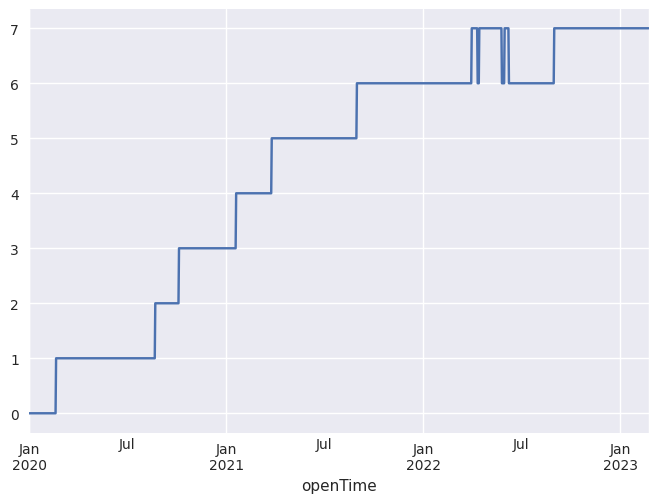

In [36]:
i = 10
((rk.ge(cond.sum(axis = 1) - select * i,axis = 0) & rk.lt(cond.sum(axis = 1) - select * (i-1),axis = 0))).sum(axis = 1).plot()

<AxesSubplot:>

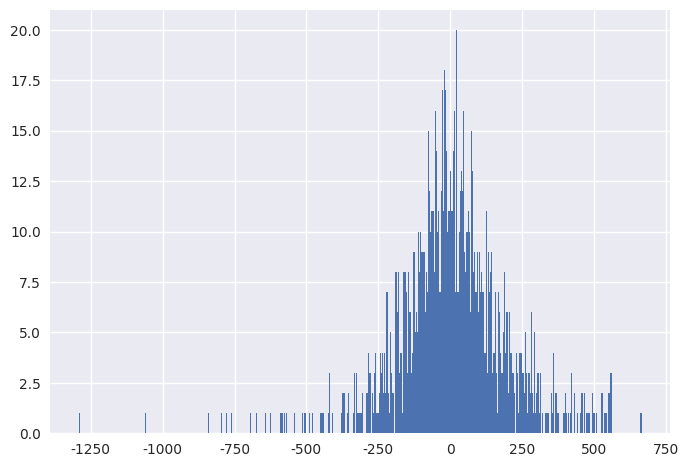

In [50]:
result[result != 0].hist(bins = 500)

In [ ]:
strategies = {
    # 'BuyerRatio*Low/High.Rank.Skew.Max_Reverse':[72,136],
    # 'quoteAssetVolume*Close/Open.Max.Pct_Change.Skew_Reverse':[24,[480,288,312]],
    # 'Open/Close.Std.Kurt.Std_Reverse':[720,[168,144,264]],
    # 'BuyerRatio*Low/High.Rank.Skew.Max_Reverse':[72,[136]],
    # 'Close/High.Skew':[168,[152]],
    # 'BuyerRatio*Open/Close.Pct_Change.SignedPower.Quantile25':[24,[152,192]],

    # 'Open/Close.SignedPower.Kurt.Abs_Reverse':[72,[456]],
    # 'Open/Close.Kurt.Abs_Reverse':[72,[160]]
    'Close.Pct_Change':[168,[168]]

}

nav = {}



subset = categories['all']
for name,params in strategies.items():
    selected = 10
    data = name.replace('_Reverse','').split('.')
    formula = '.'.join(data[1:])
    data = data[0]
    # print(name)
    factor = calc_factors(calc_input_data(df_data,data),formula,params[1])
    factor1 = factor[subset].sort_index().resample(FREQ).last()
    factor = factor1.sort_index().resample(FREQ).last()
    
    market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
    volume = df_data['quoteAssetVolume'].sort_index().rolling(params[0]).sum().fillna(0)
    volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
    GLOBAL_FILTER = market_filter & (volume_filter>0.5)
    GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()    
    cond = GLOBAL_FILTER[subset]

    if '_Reverse' in name:
        factor *= -1


    select = cond.sum(axis = 1) * selected * 0.01
    select = select.apply(lambda x:max(np.floor(x),3))




    rk = factor[cond].rank(axis = 1,ascending = True,method = 'dense')

    long_signal = rk.copy()
    long_signal[:] = 0
    short_signal = long_signal.copy()

    long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
    short_signal[rk.le(select,axis = 0)] = -1 

    long_result = fast_backtest(ret,long_signal)#.sum(axis = 1)
    short_result = fast_backtest(ret,short_signal)#.sum(axis = 1)

    result = ((long_result + short_result)/2).sum(axis = 1)
    long_result = long_result.sum(axis = 1)
    short_result = short_result.sum(axis = 1)



    # show_return(result.loc[datetime(2021,1,1):],figsize= (12,10))
    score = show_performance_metrics(result.loc[datetime(2021,1,1):],show = False)['FitnessValue']
    # stress_score.append(score)
    nav[name] = result.loc[datetime(2021,1,1):]#SAMPLE_END_DATE
    # break
result = pd.DataFrame(nav).sum(axis = 1)#.cumsum()
result /= pd.DataFrame(nav).shape[1]
show_return(result.loc[datetime(2021,1,1):],figsize= (10,8),vline = False)


In [ ]:
result = pd.DataFrame(nav).sum(axis = 1)#.cumsum()
result /= pd.DataFrame(nav).shape[1]
show_return(result.loc[datetime(2021,1,1):],figsize= (10,8))


In [ ]:
pd.DataFrame(nav).cumsum().plot()

In [ ]:
def show_return(result,bm = None,bm_name = 'CryptoMarket',figsize= (14,10),vline = True):

    fig = plt.figure(figsize=figsize,constrained_layout=False)
    gs = fig.add_gridspec(20, 20)

    ax = fig.add_subplot(gs[:10, :])

    ax = result.cumsum().plot(ax = ax,title = 'Strategy Performance')
    result.cumsum()[result.cumsum()==result.cumsum().cummax()].reset_index().rename({0:'Profit'},axis = 1).plot.scatter(ax = ax,x=result.index.name,y='Profit',color= 'limegreen')
    if vline:
        plt.axvline(x=SAMPLE_END_DATE,c='firebrick',alpha= 0.5,ls = '--')
        plt.axvline(x=VALID_END_DATE,c='silver',alpha= 0.7,ls = '--')
        plt.axvline(x=INSAMPLE_END_DATE,c='silver',alpha= 0.5,ls = '--')


    # ax = fig.add_subplot(gs[:10, 10:])

    performance_metrics = show_performance_metrics(result,show = False)
    content = ''
    content += 'Sharpe:%.2f\n'%(performance_metrics['Sharpe'])
    content += 'Profit/Mdd:%.2f\n'%(performance_metrics['Profit_mdd'])
    content += 'Net Profit(%%):%.2f\n'%(performance_metrics['Net_profit(%)'])
    content += 'MDD(%%):%.2f\n'%(performance_metrics['MDD(%)'])

    ax.text(0.85,0., content,
            verticalalignment='baseline',
            fontsize = 'large',
            transform=ax.transAxes)
    ax.set_xlabel('')


    ax = fig.add_subplot(gs[12:15, :])
    DD = result.cumsum().cummax()-result.cumsum()
    DD /= 10**4
    DD.plot(ax = ax,title = 'DrawDown',color=  'crimson')
    ax.set_xlabel('')

    ax = fig.add_subplot(gs[17:, :])
    monthly = result.resample('M').sum().loc[datetime(2021,1,1):]
    month_table = {}
    for year in monthly.index.year.unique().to_list():
        month_table[year] = monthly[monthly.index.year == year].to_list()
        while len(month_table[year]) <12:
            month_table[year].append(0)

    month_table = pd.DataFrame(month_table)
    month_table.index += 1
    month_table = month_table.T / 10**4 

    colors = ["lemonchiffon","lightsalmon"]
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap",colors) 

    sns.heatmap(month_table,fmt = '.2%', annot=True,cmap=cmap1,cbar=False,ax = ax,vmax = month_table.stack().quantile(0.95),vmin = month_table.stack().quantile(0.25))
    ax.set_title('Monthly Return')
    plt.yticks(rotation=0)

In [ ]:
formula

## Subsets

In [ ]:
subsets = ['all','token','coin','Ethereum','bnb-chain','defi','nft','gaming']

In [ ]:
name = metrics.index[10]

stress_score = {}
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]
# print(name)
factor1 = calc_factors(calc_input_data(df_data,data),formula)


factor = factor1.sort_index().resample(FREQ).last()
cond = GLOBAL_FILTER 

if '_Reverse' in name:
    factor *= -1

    
for subset in subsets[:]:
    subset_name = subset
    subset = categories[subset_name]
    if subset_name != 'all':
        subset = np.unique([sym + 'usdt' for sym in subset])

    market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
    volume = df_data['quoteAssetVolume'].sort_index().rolling(7*24).sum().fillna(0)
    volume_filter = volume[(market_filter)][subset].rank(axis = 1,pct = True,ascending = True,method = 'dense')
    filter = market_filter[subset] & (volume_filter>0.5)
    filter = filter.resample('D').last()
    cond = filter.copy()




    factor_subset = factor[subset]
    ret_subset = ret[subset]

    selected = 10
    select = cond.sum(axis = 1) * selected * 0.01
    select = select.apply(lambda x:max(np.floor(x),2))
    


    rk = factor_subset[cond].rank(axis = 1,ascending = True,method = 'dense')


    long_signal = rk.copy()
    long_signal[:] = 0
    short_signal = long_signal.copy()

    long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
    short_signal[rk.le(select,axis = 0)] = -1 

    long_result = fast_backtest(ret,long_signal)#.sum(axis = 1)
    short_result = fast_backtest(ret,short_signal)#.sum(axis = 1)

    result = ((long_result + short_result)/2).sum(axis = 1)
    long_result = long_result.sum(axis = 1)
    short_result = short_result.sum(axis = 1)

    score = show_performance_metrics(result.loc[datetime(2021,1,1):],show = False)['FitnessValue']
    stress_score[subset_name] = result.loc[datetime(2021,1,1):]
    # break

In [ ]:
list(itertools.product([24*7],repeat = 3))[0]

In [ ]:
cmap = cm.get_cmap('tab20',pd.DataFrame(stress_score).shape[1]) # Colour map (there are many others)

pd.DataFrame(stress_score).loc[datetime(2021,1,1):].cumsum().plot(colormap=cmap)


In [ ]:
list(itertools.product(list(range(24,30*24 + 8,8)),repeat = params))

## Hypertune First

In [ ]:
name = metrics.index[10]
print(name)
stress_score = {}
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

operators = formula.split('.')
vol_len = [24,24*3,24*7,24*14,24*30]
params = sum([1 for operator in operators if operator not in FORMULAS_PARAM_FREE])
params = list(itertools.product(list(range(24,30*24 + 8,8)),repeat = params))
params = list(itertools.product(vol_len,params))

np.random.shuffle(params)

print(len(params))

In [ ]:
# list()
list(itertools.product(list(range(24,24*8,24)),params))
params[0]

In [ ]:
# param[param[0]] + list(param[1])
tuple([param[0]] + list(param[1]))

In [ ]:
','.join([f'{value:.6f}' for value in list(IS_score.values())])
','.join([value for value in list(IS_score.keys())])

In [ ]:
tmp = pd.DataFrame(hypertune_metrics).T
tmp.index.names = ['vol_len'] + [f'len{i+1}'for i in range(len(operators))]
tmp
# [f'len{i+1}'for i in range(len(operators))]

In [ ]:
print(name)
tmp1 = tmp.reset_index()
tmp1[tmp1.len1>tmp1.len2].sort_values('len1')

In [ ]:
720+408

In [ ]:
factor.shape

## Hypertune Second

In [ ]:
strategies = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_metrics.csv').Strategy.sort_values().to_list()


In [ ]:
import hiplot,glob
files = glob.glob('./output/hypertune/level1/*.csv')
_dir = files[10]

df = pd.read_csv(_dir)


plt = hiplot.Experiment.from_dataframe(df)
plt.display()


In [ ]:
tmp = df[(df['FitnessValue']>0) & (df['FitnessValue']<df.FitnessValue.drop_duplicates().quantile(0.99))].sort_values('FitnessValue')#.drop_duplicates('Sharpe')
tmp = tmp[(tmp['FitnessValue']>=tmp['FitnessValue'].drop_duplicates().quantile(0.75))]
tmp#.drop_duplicates('Sharpe')

In [ ]:
name = strategies[int(_dir.split('_')[-1][:-4])]

data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]
operators = formula.split('.')


In [ ]:
tmp1.len1.quantile(0.25)
vol_len = tmp['vol_len'].unique()
param_count = sum([1 for operator in operators if operator not in FORMULAS_PARAM_FREE])
params = []
for i in range(param_count):
    param = tmp[tmp.columns[i+1]]
    start = int(np.floor(tmp[tmp.columns[1]].quantile(0.25) / 8) * 8)
    end = int(np.floor(tmp[tmp.columns[1]].quantile(0.95) / 8) * 8)
    params.append(list(range(start,end + 8,8)))
    # break
# params[1]
tmp[tmp.columns[1]].quantile(0.95)

In [ ]:
len(params)
params[i]
# param_count
params[0]

In [ ]:
result = list(itertools.product(*params[:]))
result = list(itertools.product(vol_len,result))

len(result)
result[:5]

In [ ]:
total = int(tmp.shape[0]/2)
partial = int(total/5)
i = 4
selected = tmp.iloc[tmp.shape[0] - partial * (i+1) : tmp.shape[0] - partial * (i)]
selected.iloc[np.random.randint(0,selected.shape[0],size = 2)]

In [ ]:
ls = []
for i in range(5):
    selected = tmp.iloc[tmp.shape[0] - partial * (i+1) : tmp.shape[0] - partial * (i)]
    selected = selected.iloc[np.random.randint(0,selected.shape[0],size = 2)]
    ls.append(selected)

selected#.shape
selected = pd.concat(ls,axis = 0)
selected.sort_values('')

In [ ]:
test_dict ={}
test_dict[tuple(selected[selected.columns[:param_count+1]].values[0])] = [100]
test_dict

In [ ]:
len(glob.glob('./output/hypertune/level1/*.csv'))

In [ ]:
selected

In [ ]:
name = strategies[int(_dir.split('_')[-1][:-4])]

data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]
operators = formula.split('.')

param = (336,(656,))
factor1 = calc_factors(calc_input_data(df_data,data),formula,param[1])
factor = factor1.sort_index().resample(FREQ).last()
cond = GLOBAL_FILTER 


market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(param[0]).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()


selected = 10
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]
# print(name)

select = cond.sum(axis = 1) * selected * 0.01
select = select.apply(lambda x:max(np.floor(x),3))



if '_Reverse' in name:
    factor *= -1


rk = factor[cond].rank(axis = 1,ascending = True,method = 'dense')

long_signal = rk.copy()
long_signal[:] = 0
short_signal = long_signal.copy()

long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
short_signal[rk.le(select,axis = 0)] = -1 

long_result = fast_backtest(ret,long_signal)#.sum(axis = 1)
short_result = fast_backtest(ret,short_signal)#.sum(axis = 1)

result = ((long_result + short_result)/2).sum(axis = 1)
long_result = long_result.sum(axis = 1)
short_result = short_result.sum(axis = 1)


score = show_performance_metrics(result.loc[datetime(2021,1,1):],show = False)
IS_score = show_performance_metrics(result.loc[datetime(2021,1,1):INSAMPLE_END_DATE],show = False)#['FitnessValue']
OS_score = show_performance_metrics(result.loc[datetime(2021,1,1):SAMPLE_END_DATE],show = False)
# param = {'len1':param[0],'len2':param[1]}
hypertune_metrics[tuple([param[0]] + list(param[1]))] = IS_score
result.loc[datetime(2021,1,1):].cumsum().plot()
score

In [ ]:
result.loc[datetime(2021,1,1):SAMPLE_END_DATE].cumsum().plot()
IS_score